In [52]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

In [53]:
import random

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def cmp(a, b):
    # when a > b return 1; when a < b return -1;when a == b return 0
    return int((a > b)) - int((a < b))


def draw_card():
    return random.sample(deck, 1)[0]


# return true if the ace is usable
def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):
    return sum_hand(hand) > 21


def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):
    return sorted(hand) == [1, 10]

# action(0, 1, 2) -> (stay, hit, double)


class PokerAgent:
    def __init__(self, natural=True):
        self.action_space = [0,1,2]
        self.state_size = [1, 3]
        self.natural = natural
        self.player = []
        self.dealer = []
        self.reset()

    def step(self, action):
        # stand
        if action == 0:
            done = True
            # dealer's turn
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        # hit
        elif action == 1:
            self.player.append(draw_card())
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        # double down
        else:
            self.player.append(draw_card())
            done = True
            if is_bust(self.player):
                reward = -1 * 2
            # dealer's turn
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card())
                reward = cmp(score(self.player), score(self.dealer)) * 2

        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.player = []
        self.dealer = []
        self.dealer.append(draw_card())
        self.player.append(draw_card())
        self.player.append(draw_card())
        return self.get_obs()

In [54]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [55]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

## Temporal_Difference

In [56]:
class TDAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):

        self.q_values = defaultdict(lambda: np.zeros(3)) # Q table

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.epsilon:
            return random.randint(0,2)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [58]:
# hyperparameters
learning_rate = 0.01
n_episodes = 5000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

TDagent = TDAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [59]:
env = PokerAgent()
for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    done = False

    # play one episode
    while not done:
        action = TDagent.get_action(obs)
        next_obs, reward, terminated, truncated = env.step(action)

        # update the TDagent
        TDagent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    TDagent.decay_epsilon()

100%|█████████████████████████████████████████████████████████████████████| 5000000/5000000 [01:50<00:00, 45077.01it/s]


In [61]:
"""env = gym.make("Blackjack-v1", sab=True)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = TDagent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the TDagent
        TDagent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    TDagent.decay_epsilon()"""

'env = gym.make("Blackjack-v1", sab=True)\nenv = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)\nfor episode in tqdm(range(n_episodes)):\n    obs, info = env.reset()\n    done = False\n\n    # play one episode\n    while not done:\n        action = TDagent.get_action(obs)\n        next_obs, reward, terminated, truncated, info = env.step(action)\n\n        # update the TDagent\n        TDagent.update(obs, action, reward, terminated, next_obs)\n\n        # update if the environment is done and the current obs\n        done = terminated or truncated\n        obs = next_obs\n\n    TDagent.decay_epsilon()'

## Monte Carlo

In [65]:
class MCAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):

        self.q_values = defaultdict(lambda: np.zeros(3)) # Q table
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.G = 0
        
        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.epsilon:
            return random.randint(0,2)
        else:
            return int(np.argmax(self.q_values[obs]))
   
    def every_visit_update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        self.G = self.discount_factor * self.G + reward
        self.returns_sum[(obs, action)] += self.G
        self.returns_count[(obs, action)] += 1
        self.q_values[obs][action] = self.returns_sum[(obs, action)] / self.returns_count[(obs, action)]

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [70]:
# hyperparameters
learning_rate = 0.01
n_episodes = 5000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

MCagent = MCAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [71]:
env = PokerAgent()
for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    done = False
    MCagent.G = 0

    # play one episode
    while not done:
        action = MCagent.get_action(obs)
        next_obs, reward, terminated, truncated = env.step(action)

        # update the MCagent
        MCagent.every_visit_update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    MCagent.decay_epsilon()

100%|█████████████████████████████████████████████████████████████████████| 5000000/5000000 [01:22<00:00, 60970.56it/s]


### Policy Comparison

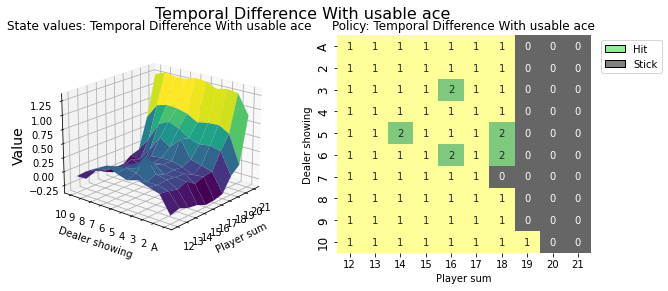

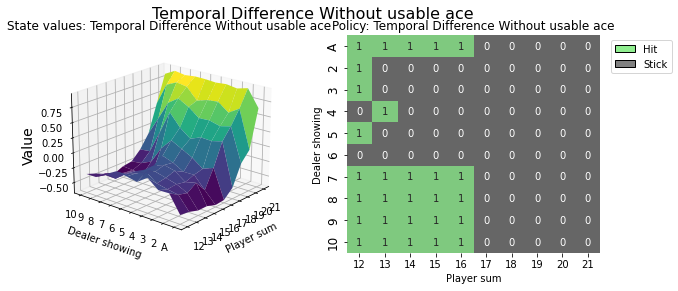

In [72]:
value_grid, policy_grid = create_grids(TDagent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="Temporal Difference With usable ace")
plt.show()

value_grid, policy_grid = create_grids(TDagent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Temporal Difference Without usable ace")
plt.show()

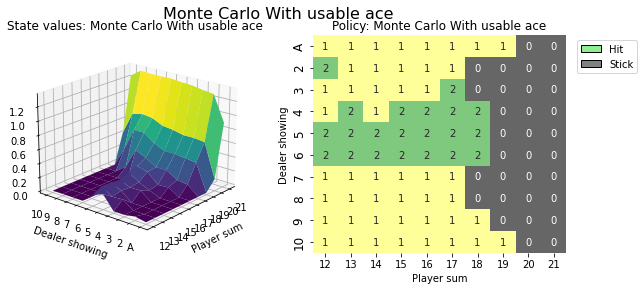

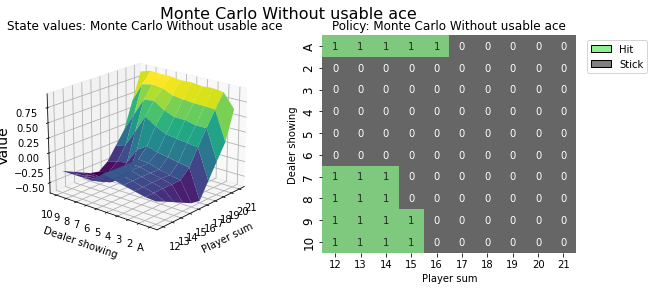

In [73]:
value_grid, policy_grid = create_grids(MCagent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="Monte Carlo With usable ace")
plt.show()

value_grid, policy_grid = create_grids(MCagent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Monte Carlo Without usable ace")
plt.show()

### Win Rate

In [75]:
"""env = gym.make("Blackjack-v1", sab=True)
Random_win = 0
Random_lose = 0
Random_draw = 0
for episode in tqdm(range(50000)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward==1 :
        Random_win += 1
    if reward==-1 :
        Random_lose += 1
    if reward==0 :
        Random_draw += 1

TD_win = 0
TD_lose = 0
TD_draw = 0
for episode in tqdm(range(50000)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = int(np.argmax(TDagent.q_values[obs]))
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward==1 :
        TD_win += 1
    if reward==-1 :
        TD_lose += 1
    if reward==0 :
        TD_draw += 1

MC_win = 0
MC_lose = 0
MC_draw = 0
for episode in tqdm(range(50000)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = int(np.argmax(MCagent.q_values[obs]))
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward==1 :
        MC_win += 1
    if reward==-1 :
        MC_lose += 1
    if reward==0 :
        MC_draw += 1"""

'env = gym.make("Blackjack-v1", sab=True)\nRandom_win = 0\nRandom_lose = 0\nRandom_draw = 0\nfor episode in tqdm(range(50000)):\n    obs, info = env.reset()\n    done = False\n\n    # play one episode\n    while not done:\n        action = env.action_space.sample()\n        obs, reward, terminated, truncated, info = env.step(action)\n        done = terminated or truncated\n    if reward==1 :\n        Random_win += 1\n    if reward==-1 :\n        Random_lose += 1\n    if reward==0 :\n        Random_draw += 1\n\nTD_win = 0\nTD_lose = 0\nTD_draw = 0\nfor episode in tqdm(range(50000)):\n    obs, info = env.reset()\n    done = False\n\n    # play one episode\n    while not done:\n        action = int(np.argmax(TDagent.q_values[obs]))\n        obs, reward, terminated, truncated, info = env.step(action)\n        done = terminated or truncated\n    if reward==1 :\n        TD_win += 1\n    if reward==-1 :\n        TD_lose += 1\n    if reward==0 :\n        TD_draw += 1\n\nMC_win = 0\nMC_lose = 0

In [ ]:
"""print("Random Policy        win rate:", Random_win/50000)
print("                    lose rate:", Random_lose/50000)
print("                    draw rate:", Random_draw/50000)

print("Temporal Difference  win rate:", TD_win/50000)
print("                    lose rate:", TD_lose/50000)
print("                    draw rate:", TD_draw/50000)

print("Monte Carlo          win rate:", MC_win/50000)
print("                    lose rate:", MC_lose/50000)
print("                    draw rate:", MC_draw/50000)"""